# Classificação de imagens usando CNN e Transfer Learning

### Problema em estudo
- Neste problema, será utilizado um modelo CNN para classificar se as imagens contêm um cachorro ou um gato. O conjunto de dados Dogs vs. Cats é um conjunto de dados padrão de visão computacional que envolve a classificação de fotos como contendo um cão ou gato

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns


seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

## Carregadno e Extraindo Dados

In [ ]:
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("C:/Users/User01/Documents/GitHub/BootCamp Geração Tech Unimed BH/Treinando Redes Neurais/dogs-vs-cats.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

In [2]:
TRAIN_DIR_PATH = "train"
file_names = os.listdir(TRAIN_DIR_PATH)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 1002 number of images in directory.


In [3]:
def to_dataframe(file_names):
    files, labels = list(), list()
    for file in file_names:
        files.append(file)
        labels.append(file[:3])
    df = pd.DataFrame({'filename':files, 'label':labels})
    return df

df = to_dataframe(file_names)

In [4]:
df.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.101.jpg,cat


## Analisando Dados

distribuição de rótulos do conjunto de dados:
 cat    501
dog    501
Name: label, dtype: int64


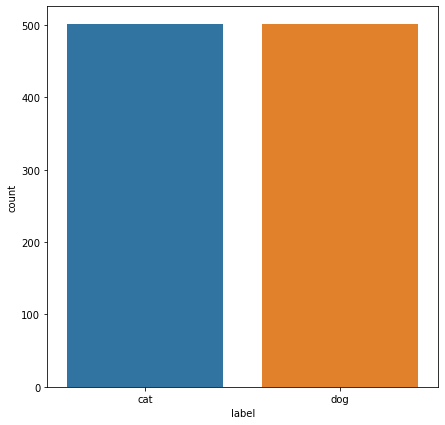

In [5]:
print('distribuição de rótulos do conjunto de dados:\n',df['label'].value_counts())

plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.show()

In [6]:
cat = [file for file in file_names if file[:3]=='cat']
dog = [file for file in file_names if file[:3]=='dog']

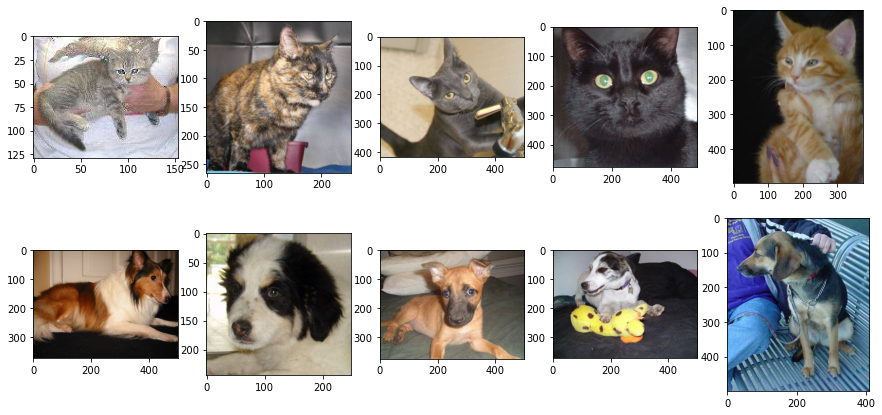

In [7]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.random.randint(0,len(cat),5), start=1):
    im = img.imread('./train/'+cat[c])
    plt.subplot(2,5,i)
    plt.imshow(im)
    
for i, c in enumerate(np.random.randint(0,len(dog),5), start=6):
    im = img.imread('./train/'+dog[c])
    plt.subplot(2,5,i)
    plt.imshow(im)

Observando algumas fotos aleatórias no diretório, as fotos são coloridas e têm formas e tamanhos diferentes.

## Dividindo Dados

In [8]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(df, test_size=0.2,random_state=seed)

In [9]:
train_set.shape, valid_set.shape

((801, 2), (201, 2))

train set distribution:
 cat    404
dog    397
Name: label, dtype: int64

valid set distribution:
 dog    104
cat     97
Name: label, dtype: int64



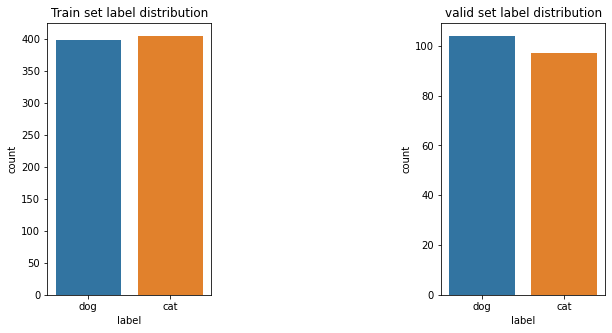

In [10]:
print('train set distribution:\n',train_set['label'].value_counts())
print('\nvalid set distribution:\n',valid_set['label'].value_counts())
print()

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.countplot(x=train_set['label'], order=['dog','cat'])
plt.title('Train set label distribution')

plt.subplot(1,3,3)
sns.countplot(x=valid_set['label'], order=['dog','cat'])
plt.title('valid set label distribution')
plt.show()

## Gerador de dados de imagem e aumento de dados

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

WIDTH, HEIGHT = 150, 150
batch_size = 32

In [12]:
train_datagenerator = ImageDataGenerator(rotation_range=15, 
                                  rescale=1./255, 
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

training_data = train_datagenerator.flow_from_dataframe(dataframe=train_set, directory='./train', x_col='filename',
                                                       y_col='label', target_size=(WIDTH, HEIGHT),
                                                       class_mode='categorical', batch_size=batch_size)

Found 801 validated image filenames belonging to 2 classes.


In [13]:
valid_datagenerator = ImageDataGenerator(rescale=1./255)
validation_data = valid_datagenerator.flow_from_dataframe(dataframe=valid_set, directory='./train', x_col='filename', y_col='label',
                                                         target_size=(WIDTH,HEIGHT), class_mode='categorical', batch_size=batch_size)

Found 201 validated image filenames belonging to 2 classes.


## Criando Modelo CNN

In [14]:
from tensorflow.keras.layers import *
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential()

model.add(DefaultConv2D(filters=32, kernel_size=5, input_shape=(WIDTH, HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=64))
model.add(DefaultConv2D(filters=64))
model.add(MaxPooling2D(pool_size=2))

model.add(DefaultConv2D(filters=128))
model.add(DefaultConv2D(filters=128))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 128)       7

## Callbacks

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', min_lr=0.00001)
checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

callbacks = [earlystop_cb, reduce_lr_cb, checkpoint_cb]

# Treinando Modelo

In [17]:
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [18]:
history = model.fit(training_data,
                   epochs=50,
                   validation_data=validation_data,
                   validation_steps=valid_set.shape[0]//batch_size,
                   steps_per_epoch=train_set.shape[0]//batch_size, 
                   callbacks=callbacks)

Epoch 1/50
25/25 [==============================] - 164s 6s/step - loss: 0.6942 - accuracy: 0.4954 - val_loss: 0.6985 - val_accuracy: 0.4792 - lr: 0.0100
Epoch 2/50
25/25 [==============================] - 161s 6s/step - loss: 0.6965 - accuracy: 0.5098 - val_loss: 0.6949 - val_accuracy: 0.4844 - lr: 0.0100
Epoch 3/50
25/25 [==============================] - 161s 6s/step - loss: 0.6945 - accuracy: 0.5124 - val_loss: 0.6921 - val_accuracy: 0.5365 - lr: 0.0100
Epoch 4/50
25/25 [==============================] - 160s 6s/step - loss: 0.6943 - accuracy: 0.4928 - val_loss: 0.6913 - val_accuracy: 0.5104 - lr: 0.0100
Epoch 5/50
25/25 [==============================] - 162s 6s/step - loss: 0.6919 - accuracy: 0.5138 - val_loss: 0.6918 - val_accuracy: 0.5521 - lr: 0.0100
Epoch 6/50
25/25 [==============================] - 163s 6s/step - loss: 0.6923 - accuracy: 0.5098 - val_loss: 0.6909 - val_accuracy: 0.5833 - lr: 0.0100
Epoch 7/50
25/25 [==============================] - 162s 6s/step - loss: 0.6

## Avaliando Modelo

In [19]:
model1 = keras.models.load_model('model.h5')

In [20]:
test_loss, test_acc = model1.evaluate(validation_data, steps=len(validation_data), verbose=1)
print('Loss: %.3f' % (test_loss))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

7/7 [==============================] - 10s 1s/step - loss: 0.6910 - accuracy: 0.5771
Loss: 0.691
Accuracy: 57.711


## Transfer Learning

In [21]:
base_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(WIDTH,HEIGHT,3))
base_model.trainable = False ## Not trainable weights

In [22]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [23]:
from tensorflow.keras.layers import *

model = keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [24]:
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(training_data,
            epochs=10,
            validation_data=validation_data,
            validation_steps=valid_set.shape[0]//batch_size,
            steps_per_epoch=train_set.shape[0]//batch_size, 
            )

Epoch 1/10
25/25 [==============================] - 351s 14s/step - loss: 0.6973 - accuracy: 0.6437 - val_loss: 0.6456 - val_accuracy: 0.6198
Epoch 2/10
25/25 [==============================] - 348s 14s/step - loss: 0.6176 - accuracy: 0.6723 - val_loss: 0.4631 - val_accuracy: 0.7865
Epoch 3/10
25/25 [==============================] - 348s 14s/step - loss: 0.6708 - accuracy: 0.7165 - val_loss: 0.5575 - val_accuracy: 0.7083
Epoch 4/10
25/25 [==============================] - 342s 14s/step - loss: 0.6757 - accuracy: 0.5332 - val_loss: 0.5520 - val_accuracy: 0.6719
Epoch 5/10
25/25 [==============================] - 339s 14s/step - loss: 0.5559 - accuracy: 0.7451 - val_loss: 0.4982 - val_accuracy: 0.7500
Epoch 6/10
25/25 [==============================] - 341s 14s/step - loss: 0.5316 - accuracy: 0.7425 - val_loss: 0.4513 - val_accuracy: 0.8125
Epoch 7/10
25/25 [==============================] - 341s 14s/step - loss: 0.6144 - accuracy: 0.6723 - val_loss: 0.4982 - val_accuracy: 0.7031
Epoch 

In [26]:
model.layers[0].trainable=True

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 15,763,650
Trainable params: 15,763,650
Non-trainable params: 0
_________________________________________________________________


In [28]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('model1.h5',save_best_only=True)
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(training_data,
            epochs=20,
            validation_data=validation_data,
            validation_steps=valid_set.shape[0]//batch_size,
            steps_per_epoch=train_set.shape[0]//batch_size, 
            callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20
25/25 [==============================] - 1138s 45s/step - loss: 0.6917 - accuracy: 0.5059 - val_loss: 0.6911 - val_accuracy: 0.4844
Epoch 2/20
25/25 [==============================] - 1129s 45s/step - loss: 0.6878 - accuracy: 0.5033 - val_loss: 0.6852 - val_accuracy: 0.4792
Epoch 3/20
25/25 [==============================] - 1128s 45s/step - loss: 0.6761 - accuracy: 0.5098 - val_loss: 0.6619 - val_accuracy: 0.4896
Epoch 4/20
25/25 [==============================] - 1126s 45s/step - loss: 0.6257 - accuracy: 0.5527 - val_loss: 0.4029 - val_accuracy: 0.8542
Epoch 5/20
25/25 [==============================] - 1136s 46s/step - loss: 0.4268 - accuracy: 0.7698 - val_loss: 1.6443 - val_accuracy: 0.5990
Epoch 6/20
25/25 [==============================] - 1148s 46s/step - loss: 0.5241 - accuracy: 0.7269 - val_loss: 0.3233 - val_accuracy: 0.8438
Epoch 7/20
25/25 [==============================] - 1150s 46s/step - loss: 0.3842 - accuracy: 0.8049 - val_loss: 0.2124 - val_accuracy: 0.9115

In [29]:
model2 = keras.models.load_model('model1.h5')

In [30]:
test_loss, test_acc = model2.evaluate(validation_data, steps=len(validation_data), verbose=1)
print('Loss: %.3f' % (test_loss))
print('Accuracy: %.3f' % (test_acc * 100.0))

7/7 [==============================] - 70s 10s/step - loss: 0.1520 - accuracy: 0.9552
Loss: 0.152
Accuracy: 95.522


## Fazendo Predições

In [31]:
sampleSubmission = pd.read_csv('sampleSubmission.csv')
test_df = sampleSubmission.copy()
test_df['id'] = test_df['id'].apply(lambda x : str(x)+'.jpg')

In [32]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(test_df, 
                                                "./test1/", 
                                                x_col='id',
                                                y_col=None,
                                                class_mode=None,
                                                target_size=(WIDTH,HEIGHT),
                                                batch_size=batch_size,
                                                shuffle=False)

Found 1500 validated image filenames.


In [33]:
predict = model1.predict(test_generator, steps=np.ceil(test_df.shape[0]/batch_size))

47/47 [==============================] - 69s 1s/step


In [34]:
sampleSubmission['label'] = np.argmax(predict, axis=-1)
sampleSubmission.to_csv('submission.csv', index=False)

In [35]:
test_df['label'] = sampleSubmission['label'].replace({ 1: 'dog', 0: 'cat' })

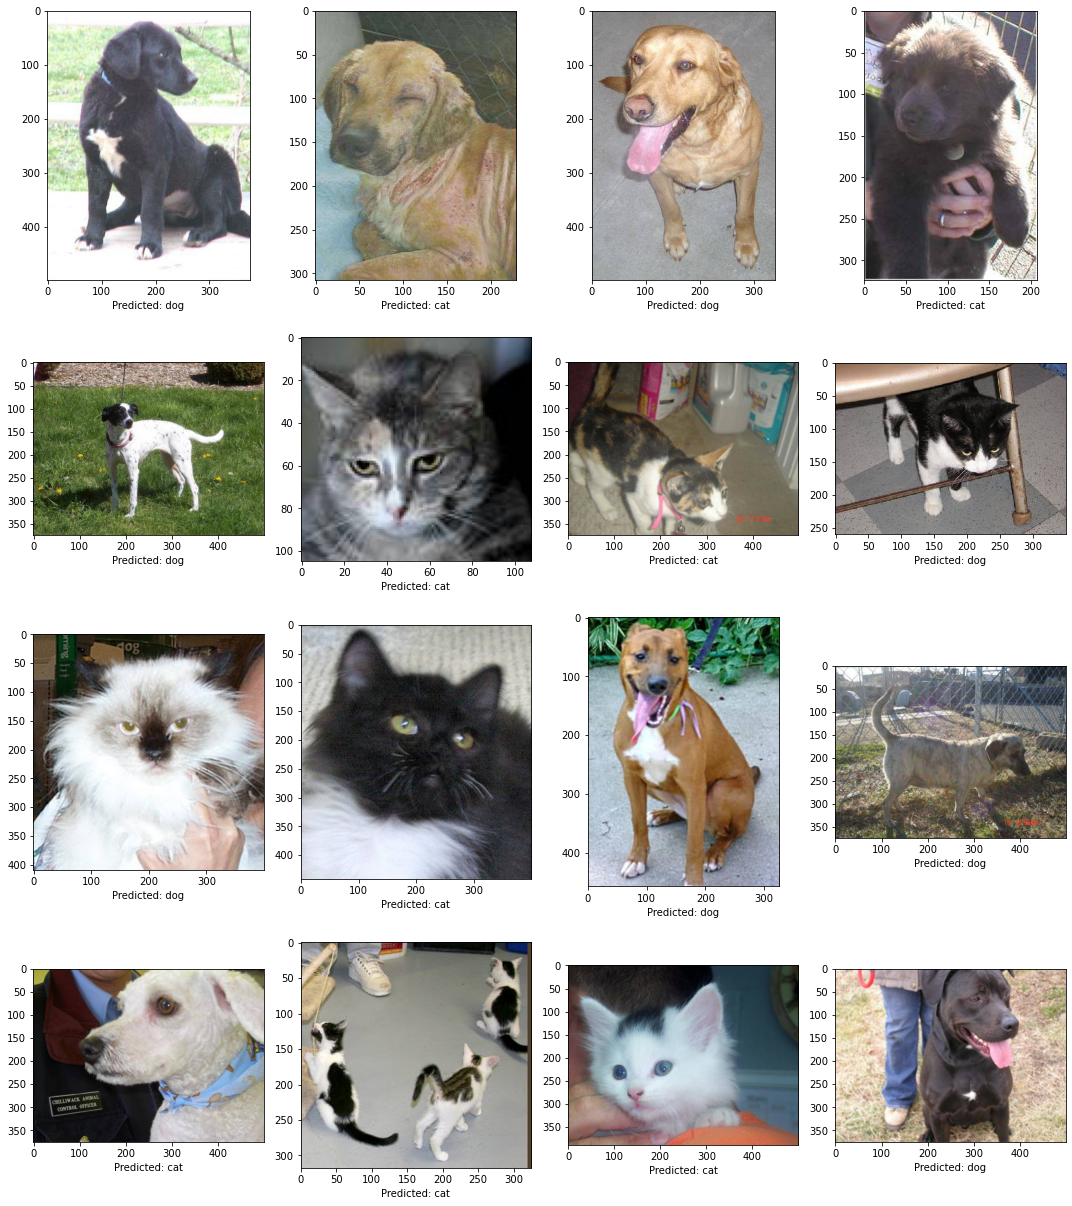

In [38]:
sample_test = test_df.values[np.random.randint(0, len(test_df), 16)]
sample_test
plt.figure(figsize=(15, 17))
for index, row in enumerate(sample_test):
    filename = row[0]
    category = row[1]
    image = img.imread("./test1/"+filename)
    plt.subplot(4, 4, index+1)
    plt.imshow(image)
    plt.xlabel('Predicted: ' + "{}".format(category) )
plt.tight_layout()
plt.show()

## A quantidade de imagens utilizadas não foi o suficiente para gerar o aprendizado necessário da máquina. 

## Por dificuldades de processamento tive que reduzir a quantidade de imagens de treino para 500 de gatos e 500 de cachorro e as imagens de teste foram 1500 